# Tarea 2 Simulacion

a) Modifique la red de actividades estocásticas para permitir que cada actividad tenga un tiempo de ejecución diferente (actualmente todas tienen un tiempo promedio de 1 mismo). Use una lista o un diccionario  para almacenar dicha información.

b) Implemente un procedimiento que permita asignar tiempos correlacionados entre actividades (actividades conectadas entre sí) por medio del método NORTA

c) Los proyectos reales no sólo se componen de actividades que se deben cumpir, sino que también de recursos limiados que se deben compartir. Además, pueden haber reglas específicas para la asignación de dichos recursos. Implemente un procedimiento que permita implementar recursos compartidos entre actividades.

In [38]:
import random
import matplotlib.pyplot as plt
import simpy
import networkx as nx  
import numpy as np
from scipy.stats import poisson
from Norta import Norta as Nt

Primero tenemos la clase que define las actividades, utilizando métodos de simpy y modificamos el ejemplo para que el activity process reciba un argumento observation si es que la actividad está correlacionada, además se le asigna una distribucion diferente a cada nodo para generar distintos tiempos. 

In [39]:
class ActivityProcess(object):
    def __init__(self, env, name, observation = []):
        self.env = env
        self.name = name
        self.observation = observation
        
    def waitup(self, node, myEvent):
        # PEM illustrating "waitevent"# wait for "myEvent" to occur
        evnt = [e.event for e in myEvent]
        yield self.env.all_of(evnt)
        print("The activating event(s) were %s at time %f" %([x.name for x in myEvent], self.env.now))
        if node==0:
            tis =random.expovariate(3.0)
        if node==1:
            tis = random.uniform(1, 3)
        if node==2:
            tis = random.triangular(1,3,4)
        if node==3:
            tis = random.expovariate(2.0)
        if node==4:
            tis = random.uniform(1, 4)           
        yield self.env.timeout(tis)
        finishtime = self.env.now
        if finishtime > SANglobal.finishtime:
            SANglobal.finishtime = finishtime
        SANglobal.F.nodecomplete[node].event.succeed()
    
    def generate_observation(self):
        if self.observation != []:
            return self.observation
        else:
            return np.random.poisson(lam=3.0)

Se crea una clase especial para el warehouse y de igual forma que en la clase anterior se entregan distintas distribuciones para cada nodo.

In [40]:
class ActivityProcess_wR(object):
    def __init__(self, env, name, tolba):
        self.env = env
        self.name = name
        self.tolba = tolba
        
    def waitup(self,node, myEvent):
        # PEM illustrating "waitevent"# wait for "myEvent" to occur
        evnt = [e.event for e in myEvent]
        yield self.env.all_of(evnt)
        with self.tolba.request() as req:
            print("%s is requesting tolba at time %f" %(self.name, self.env.now))
            yield req
            
            print("The activating event(s) were %s at time %f" %([x.name for x in myEvent],self.env.now))
            if node==0:
                tis =random.expovariate(3.0)
            if node==1:
                tis = random.uniform(1, 3)
            if node==2:
                tis = random.triangular(1,3,4)
            if node==3:
                tis = random.expovariate(2.0)
            if node==4:
                tis = random.uniform(1, 4)
            yield self.env.timeout(tis)
            finishtime = self.env.now
            if finishtime > SANglobal.finishtime:
                SANglobal.finishtime = finishtime
            SANglobal.F.nodecomplete[node].event.succeed()

Clase para iniciar las señales

In [41]:
class StartSignaller(object):
    # here we just schedule some events to fire
    def __init__(self, env, name,sEvent):
        self.env = env
        self.name = name
        self.sEvent = sEvent
        self.env.process(self.startSignals())
        
    def startSignals(self):
        yield self.env.timeout(0)
        self.sEvent.event.succeed()

Y la clase que define el evento

In [42]:
class CustomEvent(object):
    def __init__(self,env, name):
        self.name = name
        self.env = env
        self.event = self.env.event()   

Y aca llamamos a Norta, que generará una observación para las actividades necesarias:

In [43]:
class Norta(object):
    def __init__(self):
        self.env = Nt()
    
    def set_marginal(self,distribucion,**argumento):
        self.env.set_marginal(distribucion,**argumento)
    
    def set_correlation_matrix(self,R):
        self.env.set_corr_matrix(R)
    
    def generate_sample(self,m=1):
        return self.env.generate_sample(m)

Vamos a modificar el grafo para que b y c no dependan el uno del otro y pidan el mismo recurso, y para hacerlo más interesante agregaremos otro nodo, que sólo necesita el recurso y depende de `a`, que llamaremos muy originalmente `e`.

In [44]:
class SANglobal:
    F = nx.DiGraph()
    a = 0
    b = 1
    c = 2
    d = 3
    e = 4
    inTo = 0
    F.add_nodes_from([a, b, c, d, e])
    F.add_edges_from([(a,b), (a,c), (b,d), (c,d), (a,e)])
    finishtime = 0
    recurso = (b,d,e)
    correlated = [{'vertice':(b,c),'corr':0.5}]
    distribution = {b:{'func':'poisson','params':3.0}, #solo las distribuciones de las que estan correlacionadas
                   c:{'func':'poisson','params':3.0}}

Lo gráficamos

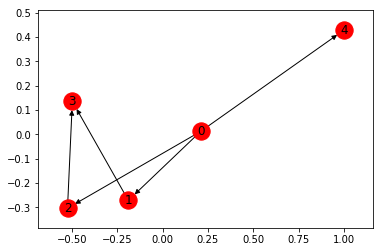

In [45]:
nx.draw_networkx(SANglobal.F)
plt.show()

Poisson function successfully added
Poisson function successfully added
Calculated correlation:
 [[1.  0.5]
 [0.5 1. ]]
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.388679
The activating event(s) were ['Complete 0'] at time 0.388679
Activity 4 is requesting tolba at time 0.388679
The activating event(s) were ['Complete 0'] at time 0.388679
The activating event(s) were ['Complete 0'] at time 2.140993
Activity 3 is requesting tolba at time 3.193109
The activating event(s) were ['Complete 1', 'Complete 2'] at time 5.537685
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.753387
The activating event(s) were ['Complete 0'] at time 0.753387
Activity 4 is requesting tolba at time 0.753387
The activating event(s) were ['Complete 0'] at time 0.753387
The activating event(s) were ['Complete 0'] at time 3.579965
Activity 3 is requesting tolba at time 3.751579
The activating event(s) were ['Complete

The activating event(s) were ['Complete 0'] at time 1.516564
Activity 3 is requesting tolba at time 2.665844
The activating event(s) were ['Complete 1', 'Complete 2'] at time 4.188998
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.232284
The activating event(s) were ['Complete 0'] at time 0.232284
Activity 4 is requesting tolba at time 0.232284
The activating event(s) were ['Complete 0'] at time 0.232284
The activating event(s) were ['Complete 0'] at time 1.280393
Activity 3 is requesting tolba at time 2.497903
The activating event(s) were ['Complete 1', 'Complete 2'] at time 3.810863
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.050369
The activating event(s) were ['Complete 0'] at time 0.050369
Activity 4 is requesting tolba at time 0.050369
The activating event(s) were ['Complete 0'] at time 0.050369
The activating event(s) were ['Complete 0'] at time 2.330127
Activity 3 is requestin

The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.055880
The activating event(s) were ['Complete 0'] at time 0.055880
Activity 4 is requesting tolba at time 0.055880
The activating event(s) were ['Complete 0'] at time 0.055880
Activity 3 is requesting tolba at time 2.584487
The activating event(s) were ['Complete 0'] at time 2.584487
The activating event(s) were ['Complete 1', 'Complete 2'] at time 4.067159
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.207928
The activating event(s) were ['Complete 0'] at time 0.207928
Activity 4 is requesting tolba at time 0.207928
The activating event(s) were ['Complete 0'] at time 0.207928
The activating event(s) were ['Complete 0'] at time 1.919061
Activity 3 is requesting tolba at time 3.279706
The activating event(s) were ['Complete 1', 'Complete 2'] at time 4.802464
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tol

The activating event(s) were ['Complete 1', 'Complete 2'] at time 4.050419
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 1.129086
The activating event(s) were ['Complete 0'] at time 1.129086
Activity 4 is requesting tolba at time 1.129086
The activating event(s) were ['Complete 0'] at time 1.129086
The activating event(s) were ['Complete 0'] at time 3.768146
Activity 3 is requesting tolba at time 3.850852
The activating event(s) were ['Complete 1', 'Complete 2'] at time 5.786967
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.094356
The activating event(s) were ['Complete 0'] at time 0.094356
Activity 4 is requesting tolba at time 0.094356
The activating event(s) were ['Complete 0'] at time 0.094356
The activating event(s) were ['Complete 0'] at time 2.342781
Activity 3 is requesting tolba at time 2.388468
The activating event(s) were ['Complete 1', 'Complete 2'] at time 4.114888
The activ

The activating event(s) were ['Complete 1', 'Complete 2'] at time 3.791670
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.131669
The activating event(s) were ['Complete 0'] at time 0.131669
Activity 4 is requesting tolba at time 0.131669
The activating event(s) were ['Complete 0'] at time 0.131669
The activating event(s) were ['Complete 0'] at time 3.019911
Activity 3 is requesting tolba at time 3.079355
The activating event(s) were ['Complete 1', 'Complete 2'] at time 6.595457
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.077541
The activating event(s) were ['Complete 0'] at time 0.077541
Activity 4 is requesting tolba at time 0.077541
The activating event(s) were ['Complete 0'] at time 0.077541
Activity 3 is requesting tolba at time 2.085596
The activating event(s) were ['Complete 0'] at time 2.085596
The activating event(s) were ['Complete 1', 'Complete 2'] at time 5.647209
The activ

Activity 3 is requesting tolba at time 3.716051
The activating event(s) were ['Complete 1', 'Complete 2'] at time 5.167822
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.649035
The activating event(s) were ['Complete 0'] at time 0.649035
Activity 4 is requesting tolba at time 0.649035
The activating event(s) were ['Complete 0'] at time 0.649035
Activity 3 is requesting tolba at time 2.503898
The activating event(s) were ['Complete 0'] at time 2.503898
The activating event(s) were ['Complete 1', 'Complete 2'] at time 4.620011
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.002804
The activating event(s) were ['Complete 0'] at time 0.002804
Activity 4 is requesting tolba at time 0.002804
The activating event(s) were ['Complete 0'] at time 0.002804
Activity 3 is requesting tolba at time 2.852629
The activating event(s) were ['Complete 0'] at time 2.852629
The activating event(s) were ['Compl

The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.302791
The activating event(s) were ['Complete 0'] at time 0.302791
Activity 4 is requesting tolba at time 0.302791
The activating event(s) were ['Complete 0'] at time 0.302791
The activating event(s) were ['Complete 0'] at time 2.365098
Activity 3 is requesting tolba at time 3.218815
The activating event(s) were ['Complete 1', 'Complete 2'] at time 5.381639
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.025927
The activating event(s) were ['Complete 0'] at time 0.025927
Activity 4 is requesting tolba at time 0.025927
The activating event(s) were ['Complete 0'] at time 0.025927
The activating event(s) were ['Complete 0'] at time 1.724022
Activity 3 is requesting tolba at time 2.225002
The activating event(s) were ['Complete 1', 'Complete 2'] at time 5.294316
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tol

Activity 1 is requesting tolba at time 0.664005
The activating event(s) were ['Complete 0'] at time 0.664005
Activity 4 is requesting tolba at time 0.664005
The activating event(s) were ['Complete 0'] at time 0.664005
Activity 3 is requesting tolba at time 3.197661
The activating event(s) were ['Complete 0'] at time 3.197661
The activating event(s) were ['Complete 1', 'Complete 2'] at time 4.662599
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.140028
The activating event(s) were ['Complete 0'] at time 0.140028
Activity 4 is requesting tolba at time 0.140028
The activating event(s) were ['Complete 0'] at time 0.140028
The activating event(s) were ['Complete 0'] at time 2.089638
Activity 3 is requesting tolba at time 2.696171
The activating event(s) were ['Complete 1', 'Complete 2'] at time 5.991939
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 1.454329
The activating event(s) were ['Compl

No handles with labels found to put in legend.


Activity 1 is requesting tolba at time 0.283159
The activating event(s) were ['Complete 0'] at time 0.283159
Activity 4 is requesting tolba at time 0.283159
The activating event(s) were ['Complete 0'] at time 0.283159
Activity 3 is requesting tolba at time 1.990487
The activating event(s) were ['Complete 0'] at time 1.990487
The activating event(s) were ['Complete 1', 'Complete 2'] at time 3.399701
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.363022
The activating event(s) were ['Complete 0'] at time 0.363022
Activity 4 is requesting tolba at time 0.363022
The activating event(s) were ['Complete 0'] at time 0.363022
The activating event(s) were ['Complete 0'] at time 2.826372
Activity 3 is requesting tolba at time 2.976161
The activating event(s) were ['Complete 1', 'Complete 2'] at time 4.048971
The activating event(s) were ['Start'] at time 0.000000
Activity 1 is requesting tolba at time 0.269972
The activating event(s) were ['Compl

<function matplotlib.pyplot.show(*args, **kw)>

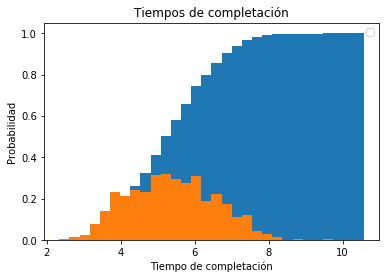

In [46]:
#Creo las observaciones para las actividades correlacionadas
Gen = Norta()
for correlations in SANglobal.correlated:
    for vertice in correlations['vertice']:
        #Gen.set_marginal(SANglobal.distribution[vertice]['func'],mu=SANglobal.distribution[vertice]['params'])
        Gen.set_marginal('poisson',mu=3.0)
    R = [[1, correlations['corr']],[correlations['corr'], 1]] # sólo efectivo para 2 dimensiones
    Gen.set_correlation_matrix(R)
    
finishtimes = []
for rep in range(1000):
    SANglobal.finishtime = 0
    env = simpy.Environment() #ambiente de simpy creado
    tolba = simpy.Resource(env, capacity=1) #Creamos nuestro recurso tolba con capacidad 1
    
    SANglobal.F.nodecomplete= []
    for i in range(len(SANglobal.F.nodes())):
        eventname = 'Complete %1d' % i
        SANglobal.F.nodecomplete.append(CustomEvent(env,eventname))
    #SANglobal.F.nodecomplete
    
    muestra = Gen.generate_sample() #genero la muestra que le voy a entregar a las dist correlacionadas
    
    activitynode = []
    for i in range(len(SANglobal.F.nodes())):
        activityname = 'Activity %1d' % i
        if i in SANglobal.recurso:
            activitynode.append(ActivityProcess_wR(env,activityname,tolba))
        else:
            activitynode.append(ActivityProcess(env,activityname))
        
    for i in range(len(SANglobal.F.nodes())):
        if i is not SANglobal.inTo:
            prenodes = SANglobal.F.predecessors(i)
            preevents = [SANglobal.F.nodecomplete[j] for j in prenodes]
            env.process(activitynode[i].waitup(i,preevents))
            
    startevent = CustomEvent(env,'Start')
    sstart = StartSignaller(env,'Signal',startevent).startSignals()
    env.process(activitynode[SANglobal.inTo].waitup(SANglobal.inTo, [startevent]))
    
    env.run(until=50)
    finishtimes.append(SANglobal.finishtime)

plt.hist(finishtimes, bins = 30, density = True, cumulative=True)  
plt.hist(finishtimes, bins = 30, density = True, cumulative=False) 
plt.title('Tiempos de completación')
plt.ylabel('Probabilidad')
plt.xlabel("Tiempo de completación")
plt.legend(loc='upper right')
plt.show         